In [1]:
import json
import os
import random
from typing import List

import cv2
import detectron2.data.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import (
    DatasetCatalog,
    DatasetMapper,
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.utils.visualizer import Visualizer

# Prepare Dataset

In [2]:
import torch
from torch.utils.data import random_split
import shutil


def cp_files(file_list: List[str], destination: str):
    for f in file_list:
        shutil.copyfile(f, os.path.join(destination, os.path.split(f)[-1]))


def move_train_test(
    img_dir: str,
    annotation_filename: str = "annotation.json",
    train_split: float = 0.8,
):
    annotation_json = os.path.join(img_dir, annotation_filename)
    dataset_filenames = []
    with open(annotation_json, "r") as f:
        data = json.load(f)
        img_annotations = data["_via_img_metadata"]
    for k, image in img_annotations.items():
        if not image["regions"]:
            # Skip images that have no region annotation, i.e. not annotated images
            continue
        if not all(
            [
                region["region_attributes"]["label_type"] == "handlabeled"
                for region in image["regions"]
            ]
        ):
            # Skip images which have regions that are not handlabeled
            continue
        dataset_filenames.append({k: image})
    train_size = int(train_split * len(dataset_filenames))
    test_size = len(dataset_filenames) - train_size
    train_dataset_files, test_dataset_files = random_split(
        dataset_filenames,
        [train_size, test_size],
        generator=torch.Generator().manual_seed(42),
    )
    train_dataset_filenames = [
        os.path.join(img_dir, values["filename"])
        for f in train_dataset_files
        for values in f.values()
    ]
    test_dataset_filenames = [
        os.path.join(img_dir, values["filename"])
        for f in test_dataset_files
        for values in f.values()
    ]
    os.makedirs(os.path.join(img_dir, "train"), exist_ok=True)
    os.makedirs(os.path.join(img_dir, "test"), exist_ok=True)
    cp_files(train_dataset_filenames, os.path.join(img_dir, "train"))
    cp_files(test_dataset_filenames, os.path.join(img_dir, "test"))
    with open(os.path.join(img_dir, "train", annotation_filename), "w") as f:
        data["_via_img_metadata"] = {
            k: v for f in train_dataset_files for k, v in f.items()
        }
        json.dump(data, f)
    with open(os.path.join(img_dir, "test", annotation_filename), "w") as f:
        data["_via_img_metadata"] = {
            k: v for f in test_dataset_files for k, v in f.items()
        }
        json.dump(data, f)


move_train_test("../data/bh")

# Setup

In [3]:
from detectron2.structures import BoxMode

hold_class_mapping = {"hold": 0, "volume": 1}


def create_dataset_dicts(
    img_dir: str, annotation_filename: str = "annotation.json"
) -> List[dict]:
    annotation_json = os.path.join(img_dir, annotation_filename)
    with open(annotation_json, "r") as f:
        img_annotations = json.load(f)["_via_img_metadata"]
    dataset = []
    for id, image in enumerate(img_annotations.values()):
        if not image["regions"]:
            # Skip images that have no region annotation, i.e. not annotated images
            continue
        if not all(
            [
                region["region_attributes"]["label_type"] == "handlabeled"
                for region in image["regions"]
            ]
        ):
            # Skip images which have regions that are not handlabeled
            continue
        record = {}
        image_filename = os.path.join(img_dir, image["filename"])
        height, width = cv2.imread(image_filename).shape[:2]

        # Create dataset dict according to detectron2 dataset specification
        # https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#standard-dataset-dicts

        record["file_name"] = image_filename
        record["height"] = height
        record["width"] = width
        record["image_id"] = id

        annotation_objects = []
        for region in image["regions"]:
            anno = region["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            # Merge point lists and flatten to [x_1, y_1, ..., x_n y_n] format
            polygons = [(x, y) for (x, y) in zip(px, py)]
            polygons = np.ravel(polygons).tolist()
            annotation_obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [polygons],
                "category_id": hold_class_mapping[
                    region["region_attributes"]["hold_type"]
                ],
            }
            annotation_objects.append(annotation_obj)
        record["annotations"] = annotation_objects
        dataset.append(record)
    return dataset

In [4]:
def create_train_augmentations(cfg):
    augs = [
        T.RandomApply(T.RandomCrop("relative", (0.5, 0.5))),
        T.ResizeShortestEdge(cfg.INPUT.MIN_SIZE_TRAIN, sample_style="choice"),
        T.RandomRotation([-20, 20]),
        T.RandomBrightness(0.75, 1.3),
        T.RandomContrast(0.75, 1.3),
        T.RandomSaturation(0.5, 2),
        T.RandomFlip(vertical=False),
    ]
    return augs

In [5]:
for dataset_type in ["train", "test"]:
    DatasetCatalog.register(
        f"hold_{dataset_type}",
        lambda d=dataset_type: create_dataset_dicts(f"../data/bh/{d}"),
    )
    MetadataCatalog.get(f"hold_{dataset_type}").thing_classes = ["hold", "volume"]
hold_metadata_train = MetadataCatalog.get("hold_train")
hold_metadata_test = MetadataCatalog.get("hold_test")

In [6]:
cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
)

cfg.DATASETS.TRAIN = ("hold_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0006
cfg.SOLVER.MAX_ITER = 1_000
#cfg.MODEL.RPN.PRE_NMS_TOPK_TRAIN = 24_000
#cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 12_000
#cfg.MODEL.RPN.POST_NMS_TOPK_TRAIN = 4_000
#cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 2_000
cfg.SOLVER.STEPS = []
cfg.INPUT.MIN_SIZE_TRAIN = [640]
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
#cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = 128
#cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[32, 64, 128]]
experiment_name = "ExperimentX"
output_dir = "output"
cfg.OUTPUT_DIR = os.path.join(output_dir, experiment_name)

# Train Model

In [7]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        mapper = DatasetMapper(
            cfg, is_train=True, augmentations=create_train_augmentations(cfg)
        )
        return build_detection_train_loader(cfg, mapper=mapper)


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
with open(os.path.join(cfg.OUTPUT_DIR,"experiment_config.yml"), "w") as f:
    f.write(cfg.dump())

In [8]:
trainer = Trainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/21 16:22:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[03/21 16:22:27 d2.engine.train_loop]: Starting training from iteration 0


/home/philipp/anaconda3/envs/cv_final/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[03/21 16:22:49 d2.utils.events]:  eta: 0:17:29  iter: 19  total_loss: 5.466  loss_cls: 1.091  loss_box_reg: 0.6623  loss_mask: 0.6901  loss_rpn_cls: 2.633  loss_rpn_loc: 0.3454  time: 1.0540  last_time: 1.1260  data_time: 0.0501  last_data_time: 0.0028   lr: 1.1989e-05  max_mem: 3548M
[03/21 16:23:10 d2.utils.events]:  eta: 0:17:06  iter: 39  total_loss: 3.451  loss_cls: 1.005  loss_box_reg: 0.6728  loss_mask: 0.6683  loss_rpn_cls: 0.7755  loss_rpn_loc: 0.3052  time: 1.0478  last_time: 1.0397  data_time: 0.0096  last_data_time: 0.0026   lr: 2.3977e-05  max_mem: 4080M
[03/21 16:23:31 d2.utils.events]:  eta: 0:16:44  iter: 59  total_loss: 2.828  loss_cls: 0.8388  loss_box_reg: 0.6183  loss_mask: 0.6308  loss_rpn_cls: 0.3733  loss_rpn_loc: 0.2857  time: 1.0377  last_time: 1.2155  data_time: 0.0029  last_data_time: 0.0036   lr: 3.5965e-05  max_mem: 4080M
[03/21 16:23:54 d2.utils.events]:  eta: 0:16:31  iter: 79  total_loss: 2.493  loss_cls: 0.651  loss_box_reg: 0.603  loss_mask: 0.5795  l

# Test Model

In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6  # confidence threshold for testing
cfg.DETECTIONS_PER_IMAGE = 300  # TODO figure out a good value
cfg.DATASETS.TEST = ("hold_test",)
predictor = DefaultPredictor(cfg)

[03/21 16:45:23 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from output/ExperimentX/model_final.pth ...


[03/21 16:45:29 d2.utils.memory]: Attempting to copy inputs of <function paste_masks_in_image at 0x7f9e750b5700> to CPU due to CUDA OOM
[03/21 16:45:34 d2.utils.memory]: Attempting to copy inputs of <function paste_masks_in_image at 0x7f9e750b5700> to CPU due to CUDA OOM


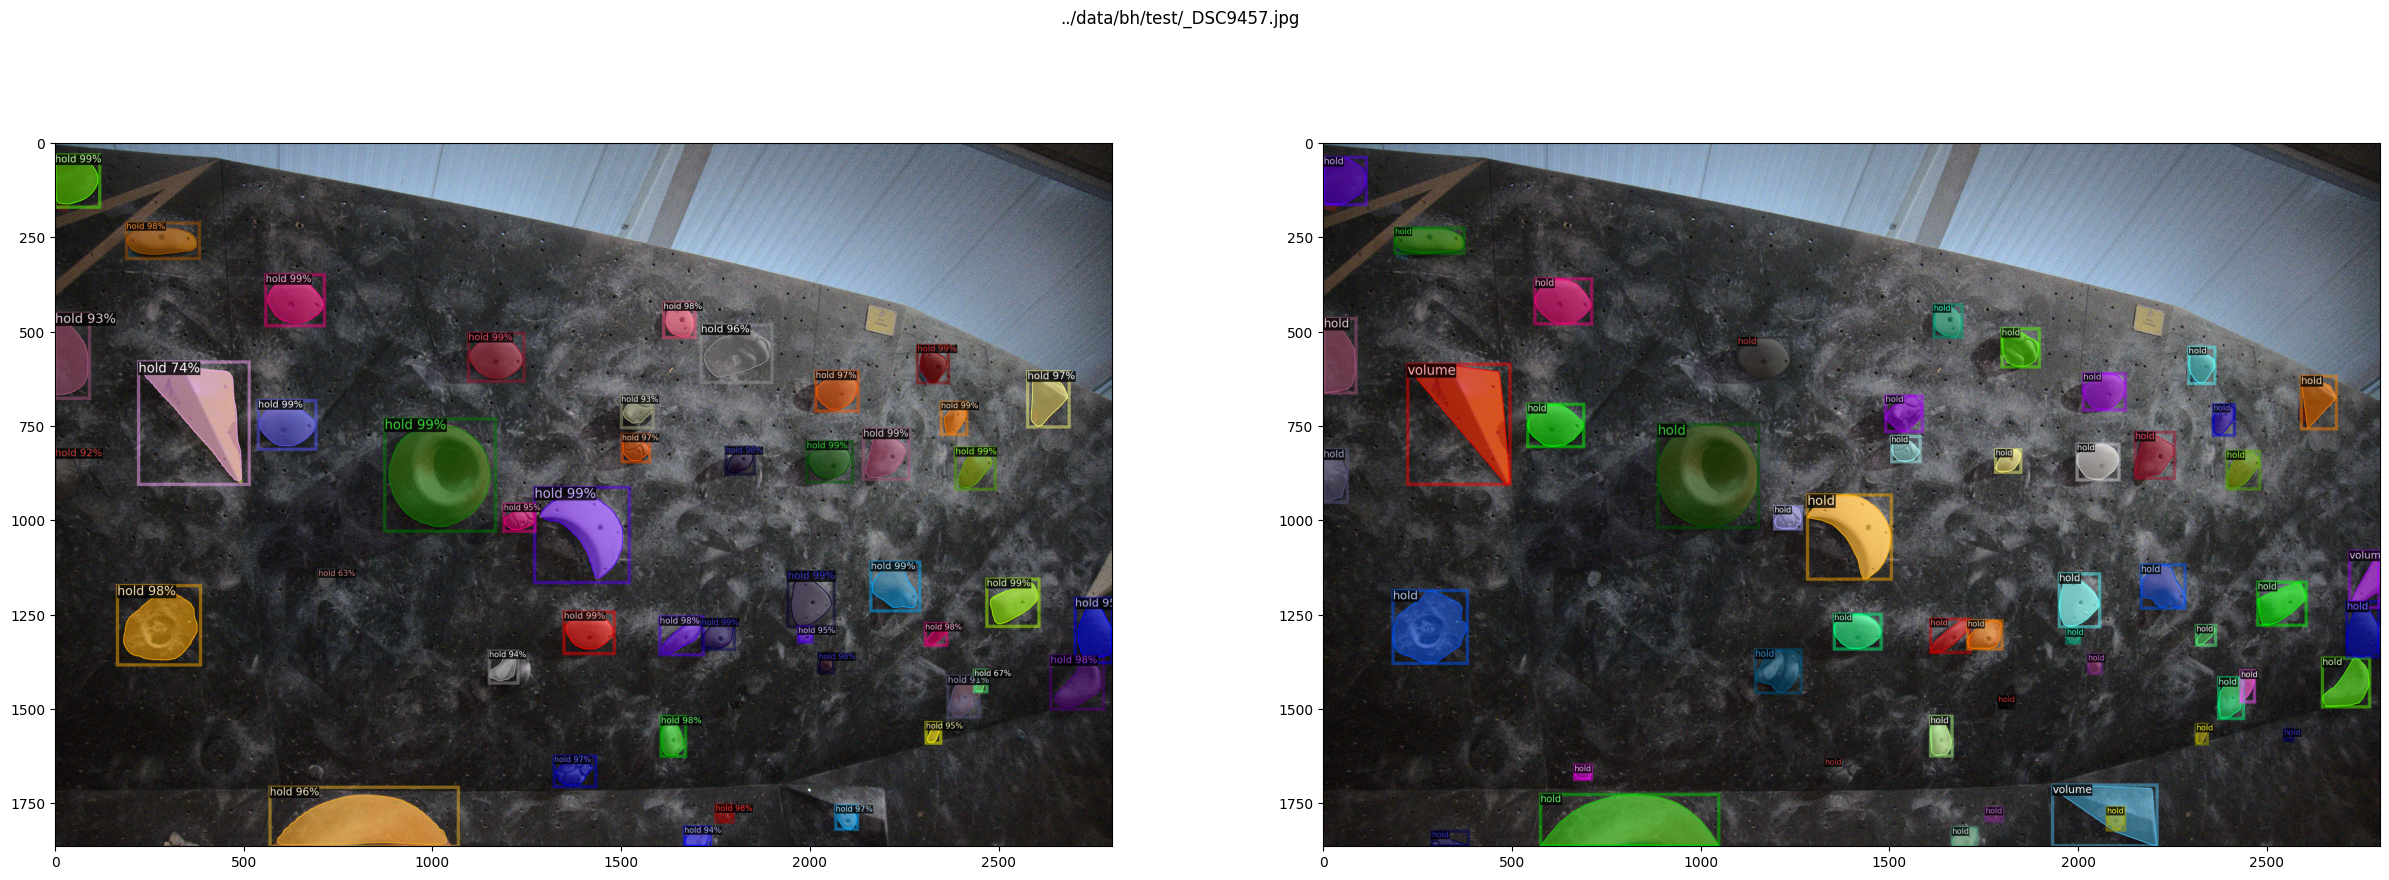

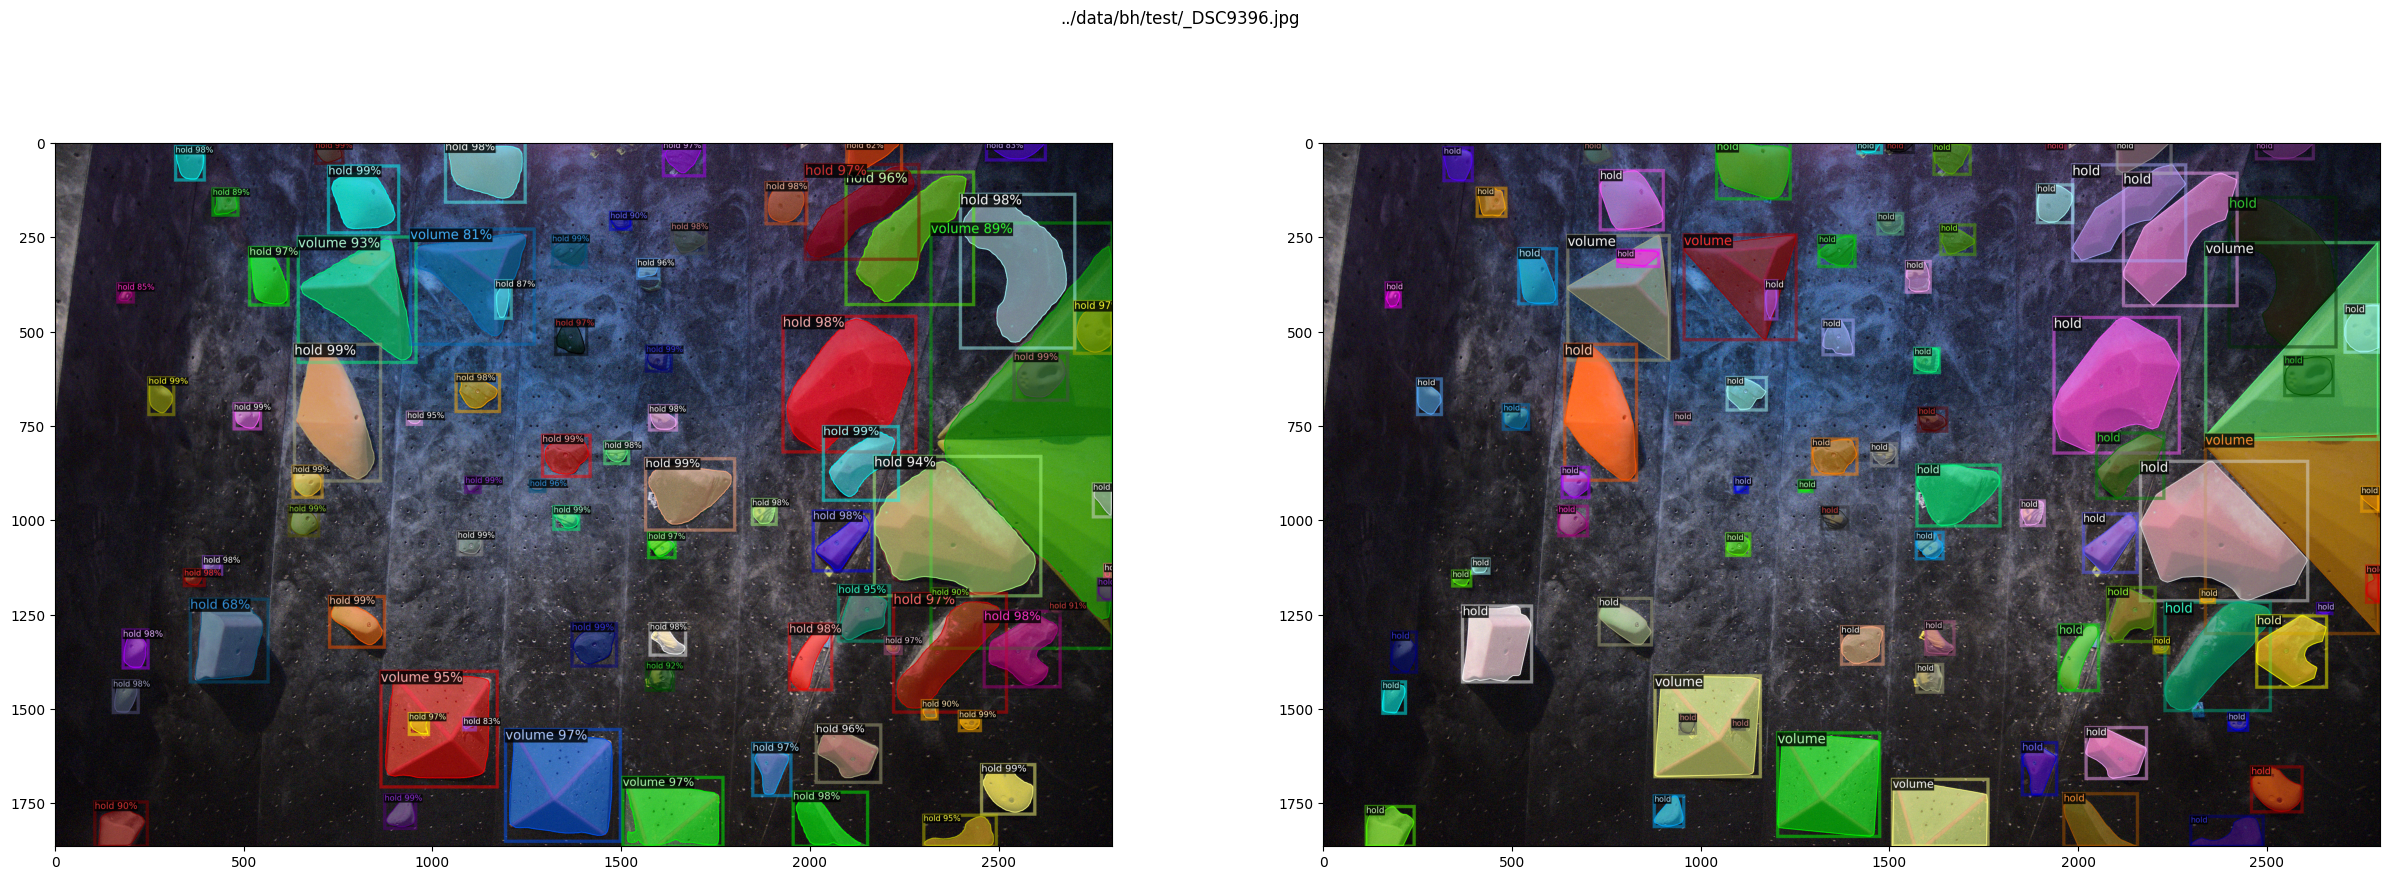

In [10]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = create_dataset_dicts("../data/bh/test")
for d_dict in random.sample(dataset_dicts, 2):
    im = cv2.imread(d_dict["file_name"])
    outputs = predictor(im)
    v = Visualizer(
        im[:, :, ::-1],
        metadata=hold_metadata_test,
        scale=0.5,
    )
    out_predictions = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    v = Visualizer(
        im[:, :, ::-1],
        metadata=hold_metadata_test,
        scale=0.5,
    )
    out_ground_truth = v.draw_dataset_dict(d_dict)
    fig, ax = plt.subplots(1, 2, figsize=(30, 10))
    fig.suptitle(d_dict["file_name"])
    fname = d_dict["file_name"].split(".")[-1]
    ax[0].imshow(out_predictions.get_image())
    ax[1].imshow(out_ground_truth.get_image())
    fig.savefig(f"{fname}-comparison.jpg", bbox_inches="tight")

In [11]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

evaluator = COCOEvaluator(
    "hold_test", output_dir="./output", max_dets_per_image=cfg.DETECTIONS_PER_IMAGE
)
test_loader = build_detection_test_loader(cfg, "hold_test")
print(inference_on_dataset(predictor.model, test_loader, evaluator))

[03/21 16:46:37 d2.evaluation.coco_evaluation]: Trying to convert 'hold_test' to COCO format ...
WARNING [03/21 16:46:37 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/hold_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[03/21 16:46:38 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|    hold    | 194          |   volume   | 16           |
|            |              |            |              |
|   total    | 210          |            |              |
[03/21 16:46:38 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/21 16:46:38 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[03/21 16:46:38 d2.data.comm

# Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output

# Prelabeling

In [75]:
from imantics import Mask
from tqdm import tqdm


def annotate_polygons(
    predictor, img_dir: str, annotation_filename: str = "annotation.json"
):
    annotation_json = os.path.join(img_dir, annotation_filename)
    with open(annotation_json, "r") as f:
        data = json.load(f)
        img_annotations = data["_via_img_metadata"]
    for k, image in tqdm(img_annotations.items()):
        if image["regions"]:
            if not all(
                [
                    region["region_attributes"].get("label_type", "") != "prelabeled"
                    for region in image["regions"]
                ]
            ):
                # We only "relabel" prelabeled images
                continue
        image_filename = os.path.join(img_dir, image["filename"])
        im = cv2.imread(image_filename)
        outputs = predictor(im)
        regions = []
        for i in range(
            len(outputs["instances"])
        ):  # Workaround since Instances obj is not iterable
            poly = outputs["instances"][i]
            pred_mask = poly.pred_masks.cpu().squeeze().numpy().astype(np.uint8)
            polygons = Mask(pred_mask).polygons().points[0]
            # Reduce number of polygon points to make manual fixing easier
            epsilon = 0.01 * cv2.arcLength(polygons, True)
            polygons = cv2.approxPolyDP(polygons, epsilon, True)
            points_x = polygons[:, 0, 0].tolist()
            points_y = polygons[:, 0, 1].tolist()
            region_dict = {
                "shape_attributes": {
                    "name": "polygon",
                    "all_points_x": points_x,
                    "all_points_y": points_y,
                },
                "region_attributes": {"label_type": "prelabeled"},
            }
            regions.append(region_dict)
        img_annotations[k]["regions"] = regions
    new_filename = "".join(
        annotation_filename.split(".")[:-1]
        + ["-prelabeled."]
        + annotation_filename.split(".")[-1:]
    )
    file_path = os.path.join(img_dir, new_filename)
    with open(file_path, "w") as f:
        json.dump(data, f)

In [76]:
annotate_polygons(predictor, "../data/bh")

100%|██████████| 1061/1061 [34:30<00:00,  1.95s/it]


# Visualize Data Augmentation

In [7]:
mapper = DatasetMapper(
    cfg, is_train=True, augmentations=create_train_augmentations(cfg)
)
loader = build_detection_train_loader(cfg, mapper=mapper)

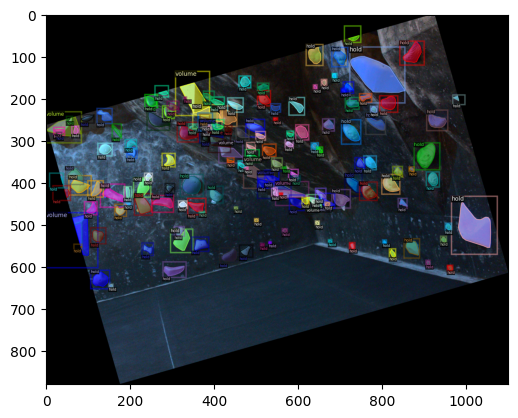

In [8]:
from detectron2.data import detection_utils as utils

for batch in loader:
    for image in batch:
        # torch (C,H,W) to (H,W,C)
        img = image["image"].permute(1, 2, 0).cpu().detach().numpy()
        img = utils.convert_image_to_rgb(img, cfg.INPUT.FORMAT)

        visualizer = Visualizer(img, metadata=hold_metadata_test, scale=1)
        target_fields = image["instances"].get_fields()
        labels = [
            hold_metadata_test.thing_classes[i] for i in target_fields["gt_classes"]
        ]
        vis = visualizer.overlay_instances(
            labels=labels,
            boxes=target_fields.get("gt_boxes", None),
            masks=target_fields.get("gt_masks", None),
        )
        fig, ax = plt.subplots()
        ax.imshow(vis.get_image()[:, :, ::-1])
        break
    break